In [2]:
import drms
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.dates import *
from datetime import datetime as dt_obj


#Path to top-level do-dem directory - edit for your system.
path_to_dodem = '/Users/jmdunca2/do-dem/'
from sys import path as sys_path
sys_path.append(path_to_dodem+'/dodem/')
import nustar_utilities as nuutil
import nustar_dem_prep as nu
import all_nu_analysis as ana
import visualize_dem_results as viz

import pickle
import importlib

In [3]:
c = drms.Client() 
c.series(r'hmi\.sharp_')
si = c.info('hmi.sharp_720s')
for try_ in ['USFLUX', 'ERRVF', 'MEANALP', 'MEANJZH', 'TOTUSJZ']:
    if try_ in si.keywords.index.tolist():
        print(try_)

USFLUX
ERRVF
MEANALP
MEANJZH
TOTUSJZ


In [132]:
si.keywords.index.tolist()

['cparms_sg000',
 'magnetogram_bzero',
 'magnetogram_bscale',
 'cparms_sg001',
 'bitmap_bzero',
 'bitmap_bscale',
 'cparms_sg002',
 'Dopplergram_bzero',
 'Dopplergram_bscale',
 'cparms_sg003',
 'continuum_bzero',
 'continuum_bscale',
 'cparms_sg004',
 'inclination_bzero',
 'inclination_bscale',
 'cparms_sg005',
 'azimuth_bzero',
 'azimuth_bscale',
 'cparms_sg006',
 'field_bzero',
 'field_bscale',
 'cparms_sg007',
 'vlos_mag_bzero',
 'vlos_mag_bscale',
 'cparms_sg008',
 'dop_width_bzero',
 'dop_width_bscale',
 'cparms_sg009',
 'eta_0_bzero',
 'eta_0_bscale',
 'cparms_sg010',
 'damping_bzero',
 'damping_bscale',
 'cparms_sg011',
 'src_continuum_bzero',
 'src_continuum_bscale',
 'cparms_sg012',
 'src_grad_bzero',
 'src_grad_bscale',
 'cparms_sg013',
 'alpha_mag_bzero',
 'alpha_mag_bscale',
 'cparms_sg014',
 'chisq_bzero',
 'chisq_bscale',
 'cparms_sg015',
 'conv_flag_bzero',
 'conv_flag_bscale',
 'cparms_sg016',
 'info_map_bzero',
 'info_map_bscale',
 'cparms_sg017',
 'confid_map_bzero',


In [133]:
hh = 5894
keys, segments = c.query('hmi.sharp_720s['+str(hh)+'][? (QUALITY<65536) ?]', 
                                 key='T_REC, USFLUX, ERRVF, LON_FWT', seg='Br')

In [134]:
keys.LON_FWT

0      -52.624886
1      -52.495975
2      -52.359764
3      -52.242069
4      -52.126118
          ...    
1275    87.683823
1276    87.669701
1277    87.717453
1278    87.785965
1279    87.718079
Name: LON_FWT, Length: 1280, dtype: float64

In [7]:
hh = 5894
keys, segments = c.query('hmi.sharp_720s['+str(hh)+'][? (QUALITY<65536) ?]', 
                                 key='T_REC, USFLUX, ERRVF, MEANALP, MEANJZH, TOTUSJZ', seg='Br')

In [27]:
def get_harp_and_times(key, dict):
    
    id_dirs = dict[key]['datapaths']
    harps = dict[key]['HARP']
    
    orbits=[]
    for id in id_dirs:
        evt_data, hdr, obsid = nu.return_submap(datapath=id, fpm='A', return_evt_hdr=True, return_obsid=True)
        time0, time1 = [nuutil.convert_nustar_time(hdr['TSTART']), nuutil.convert_nustar_time(hdr['TSTOP'])]
        timerange = [time0.datetime, time1.datetime]
        #print(timerange[0].strftime('%H-%M-%S'), timerange[1].strftime('%H-%M-%S'))
        orbits.append(timerange)
        
    return harps, orbits


def parse_tai_string(tstr,datetime=True):
    year   = int(tstr[:4])
    month  = int(tstr[5:7])
    day    = int(tstr[8:10])
    hour   = int(tstr[11:13])
    minute = int(tstr[14:16])
    if datetime: return dt_obj(year,month,day,hour,minute)
    else: return year,month,day,hour,minute




def to_float(d, epoch):
    return (d - epoch)/ np.timedelta64(1, 's')


def make_interp_usflux(usflux, t_rec, seconds=20, plot=False):
    
    ref_time = t_rec[0]
    new_times = np.arange(ref_time, t_rec[-1], np.timedelta64(seconds, 's'), dtype='datetime64')

    new_times_float = [to_float(d, np.datetime64(ref_time)) for d in new_times]
    t_rec_float = [to_float(np.datetime64(d), np.datetime64(ref_time)) for d in t_rec]

    interp_usflux = np.interp(new_times_float, t_rec_float, usflux)

    if plot:
        import matplotlib.dates as mdates
        #from matplotlib.ticker import NullFormatter, ScalarFormatter
        fig, ax = plt.subplots(figsize=(8,6))
        plt.plot(new_times, interp_usflux)
        plt.scatter(t_rec, usflux)
        plt.xticks(rotation=45)
        #ax.xaxis.set_major_formatter(mdates.DateFormatter('%D %H:%M:%S'))
        # format the x-axis with universal time
        locator = AutoDateLocator()
        locator.intervald[HOURLY] = [24] # only show every 3 hours
        formatter = DateFormatter('%D')
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)

    return interp_usflux, new_times


def get_usflux(res_files, interval_type='all'):

    rfs=res_files

    if interval_type != 'all':
        flare_res = ana.get_saved_flares(add_stdv_flares=True)
        early_starts = flare_res[0]
        late_stops = flare_res[1]

    usflxs=[]
    em10s=[]
    em7s=[]
    em5s=[]
    powerlaws=[]

    for ff in rfs:
        data, timestring, time = viz.load_DEM(ff)

        if interval_type != 'all':
            flare = ana.check_for_flare(time, early_starts, late_stops)
            if flare:
                if interval_type != 'flare':
                    continue

            else:
                if interval_type == 'flare':
                    continue

        try:
            avgusflx = data['average_usflux']
            avgusflx_rad = data['average_usflux_rad']
            avgmalp = data['average_meanalp']
            avgmjzh = data['average_meanjzh']
            avgtotjz = data['average_totjz']
            if np.log10(avgtotjz) < 11:
                print('low helicity: ', ff)
        except KeyError:
            #print(ff)
            continue
                
        usflxs.append(np.array([avgusflx, avgusflx_rad, avgmalp, avgmjzh, avgtotjz]))
        em10s.append(data['above_10MK'][0])
        em7s.append(data['above_7MK'][0])
        em5s.append(data['above_5MK'][0])
        powerlaws.append(np.array([data['powerlaws'][0][0],data['powerlaws'][1][0]]))

    return_all=True
    if return_all:
        return files_with_usflx, usflxs, em10s, em7s, em5s, powerlaws
    else:
        return files_with_usflx


def save_usflux(res_files, harp, interp_seconds=20, interval_type='all', plot=True, label=''):
    """
    For a given HARP patch + array of DEM result files, gets the HARP unsigned flux values, 
    then opens each file, finds the average value during the relevant time interval (note:interpolated!)
    and saves it as a new entry in the result dictionary, 'average_usflux'.

    Interpolation: 
    ----------------
    HARP parameters are reported every 12 minutes. We do an interpolation of those values onto an array
    with times spaced every (interp_seconds) seconds (20s default: less than typical minimum 30s DEM time
    interval length, so ensures that there will be an enclosed value for any DEM time interval occuring during
    the time the HARP patch is defined. 
    
    """
    hh=harp
    rfs=res_files
    #print(res_files)

    files_with_usflx=[]
    usflxs=[]
    em10s=[]
    em7s=[]
    em5s=[]
    powerlaws=[]
    all_times=[]

    if interval_type != 'all':
        flare_res = ana.get_saved_flares(add_stdv_flares=True)
        early_starts = flare_res[0]
        late_stops = flare_res[1]

    keys, segments = c.query('hmi.sharp_cea_720s['+str(hh)+'][? (QUALITY<65536) ?]', 
                                 key='T_REC, USFLUX, ERRVF, MEANALP, MEANJZH, TOTUSJZ, LON_FWT, LAT_FWT', seg='Br')
    if keys.empty: 
        print('No result for HARP ', hh, ' key: ', kk)
        return
    t_rec = np.array([parse_tai_string(keys.T_REC[i],datetime=True) for i in range(keys.T_REC.size)])

    usflux = np.array(keys.USFLUX)
    meanalp = np.array(keys.MEANALP)
    meanjzh = np.array(keys.MEANJZH)
    totjz = np.array(keys.TOTUSJZ)
    lon_fwt = np.array(keys.LON_FWT)
    lat_fwt = np.array(keys.LAT_FWT)
    
    interp_usflux, new_times = make_interp_usflux(usflux, t_rec, seconds=interp_seconds, plot=False)
    interp_meanalp, new_times = make_interp_usflux(meanalp, t_rec, seconds=interp_seconds, plot=False)
    interp_meanjzh, new_times = make_interp_usflux(meanjzh, t_rec, seconds=interp_seconds, plot=False)
    interp_totjz, new_times = make_interp_usflux(totjz, t_rec, seconds=interp_seconds, plot=False)
    interp_lon_fwt, new_times = make_interp_usflux(lon_fwt, t_rec, seconds=interp_seconds, plot=False)
    interp_lat_fwt, new_times = make_interp_usflux(lat_fwt, t_rec, seconds=interp_seconds, plot=False)

    for ff in rfs:
        data, timestring, time = viz.load_DEM(ff)

        if interval_type != 'all':
            flare = ana.check_for_flare(time, early_starts, late_stops)
            if flare:
                if interval_type != 'flare':
                    continue

            else:
                if interval_type == 'flare':
                    continue
                
        times_ = np.where(np.logical_and(new_times > time[0].datetime, new_times < time[1].datetime))[0]
        if len(times_) > 0:
            avgusflx=np.mean(interp_usflux[times_])
            data['average_usflux'] = avgusflx

            avgusflx_rad=np.mean(interp_usflux[times_]/np.cos(np.deg2rad(interp_lon_fwt))[times_])
            data['average_usflux_rad'] = avgusflx_rad
            
            avgmalp=np.mean(interp_meanalp[times_])
            data['average_meanalp'] = avgmalp

            avgmjzh=np.mean(interp_meanjzh[times_])
            data['average_meanjzh'] = avgmjzh

            avgtotjz=np.mean(interp_totjz[times_])
            data['average_totjz'] = avgtotjz

            with open(ff, 'wb') as f:
                 # Pickle the 'data' dictionary using the highest protocol available.
                 pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)  

            files_with_usflx.append(ff)
            usflxs.append(np.array([avgusflx, avgusflx_rad, avgmalp, avgmjzh, avgtotjz]))
            em10s.append(data['above_10MK'][0])
            em7s.append(data['above_7MK'][0])
            em5s.append(data['above_5MK'][0])
            powerlaws.append(np.array([data['powerlaws'][0][0],data['powerlaws'][1][0]]))

            all_times.extend(new_times[times_])

    


    all_times.sort()
    
    if plot and len(all_times) > 0:
        fig, ax = plt.subplots(figsize=(12,6))
        the_brad = (keys.USFLUX)/np.cos(np.deg2rad(keys.LON_FWT))/1e22
        the_blos = (keys.USFLUX)/1e22
        ax.plot(t_rec, the_brad,'o',**marker_style, label='B_rad')
        ax.plot(t_rec, the_blos, 'o', color='blue', label='B_los')
        ax.set_ylabel('Maxwells x 1e22')
        ax.set_xlabel('Time')
        ax.axvspan(all_times[0], all_times[-1], alpha=0.7, color='Pink', label='NuSTAR Times')
        ax.legend()
        plt.savefig('./figures_etc/unsigned_flux_time_profile_with_nutimes_harp_'+str(harp)+'_'+label+'.png')
        plt.close()


            

    return_all=True
    if return_all:
        return files_with_usflx, usflxs, em10s, em7s, em5s, powerlaws
    else:
        return files_with_usflx




def interval_intersect(int1, int2):
    """for two intervals
    each a tuple of datetimes
    determine if they intersect.
    """

    intersection=False
    #If int_1 starts before int2 and stops after the begining of int2
    b4 = int1[0] < int2[0]
    ea = int1[1] > int2[0]
    es = np.where(np.logical_and(b4, ea))

    if es[0].size > 0:
        intersection=True

    #If int1 starts during int2
    b4 = int1[0] > int2[0]
    ea = int1[0] < int2[1]
    es = np.where(np.logical_and(b4, ea))

    if es[0].size > 0:
        intersection=True

    return intersection
    

In [16]:
# plot=False

# with open('all_targets.pickle', 'rb') as f:
#     data = pickle.load(f)

# keys_with_harps=[]
# orbits_with_harps=[]

# keys_to_check = ['03-may-21_1','20-jul-21']
# keys_to_check = data.keys()

# keys_with_bad_vibes=['03-may-21_1', '20-jul-21']

# for kk in keys_to_check:
#     print('')
#     harps, orbits = get_harp_and_times(kk, data)
#     for hh in harps:
#         keys, segments = c.query('hmi.sharp_720s['+str(hh)+'][? (QUALITY<65536) ?]', 
#                                  key='T_REC, USFLUX, ERRVF, MEANALP, MEANJZH, TOTUSJZ, LON_FWT', seg='Br')
#         if keys.empty: 
#             print('No result for HARP ', hh, ' key: ', kk)
#             continue
#         t_rec = np.array([parse_tai_string(keys.T_REC[i],datetime=True) for i in range(keys.T_REC.size)])

#         for o in orbits:
#             if interval_intersect([t_rec[0], t_rec[-1]], o):
#                 print(kk+': HARP '+str(hh)+' in orbit: ', o[0].strftime('%H-%M-%S'), o[1].strftime('%H-%M-%S'))
#                 if kk not in keys_with_harps:
#                     if kk not in keys_with_bad_vibes:
#                         keys_with_harps.append(kk)
#                     orbits_with_harps.append(o)
                    
#             else:
#                 print(kk+': HARP '+str(hh)+' NOT in orbit: ', o[0].strftime('%H-%M-%S'), o[1].strftime('%H-%M-%S'))
            
#         #print(hh, keys.LON_FWT.values)

#         if plot:
#             fig, ax = plt.subplots(figsize=(12,6))      # define the size of the figure
#             orangered = (1.0,0.27,0,1.0)                # create an orange-red color
            
#             # define some style elements
#             marker_style = dict(linestyle='', markersize=8, fillstyle='full',color=orangered,markeredgecolor=orangered)
#             text_style = dict(fontsize=16, fontdict={'family': 'monospace'})
#             ax.tick_params(labelsize=14)
#             ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

#             the_brad = (keys.USFLUX)/np.cos(np.deg2rad(keys.LON_FWT))/1e22
#             the_blos = (keys.USFLUX)/1e22
#             #the_err = (keys.ERRVF)/np.cos(keys.LON_FWT)/1e22
#             ax.plot(t_rec, the_brad,'o',**marker_style, label='B_rad')
#             ax.plot(t_rec, the_blos, 'o', color='blue', label='B_los')
#             #ax.errorbar(t_rec, the_brad, yerr=the_err, linestyle='', color=orangered)
            
#             # ascribe the data to the axes
#             #ax.plot(t_rec, (keys.USFLUX)/(1e22),'o',**marker_style)
#             #ax.errorbar(t_rec, (keys.USFLUX)/(1e22), yerr=(keys.ERRVF)/(1e22), linestyle='', color=orangered)

#             ax.legend()
#             plt.savefig('./figures_etc/'+kk+'_HARP_'+str(hh)+'_unsigned_flux_rad.png')
#             plt.close()
            

#             fig, ax = plt.subplots(figsize=(12,6))      # define the size of the figure

            
#             # define some style elements
#             marker_style = dict(linestyle='', markersize=8, fillstyle='full',color='darkgreen', markeredgecolor='darkgreen')
#             text_style = dict(fontsize=16, fontdict={'family': 'monospace'})
#             #ax.tick_params(labelsize=14)
#             #ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
            
#             # ascribe the data to the axes
#             ax.plot(t_rec, (keys.TOTUSJZ),'o',**marker_style)
#             ax.scatter(t_rec, (keys.TOTUSJZ), linestyle='', color='darkgreen')

#             plt.savefig('./figures_etc/'+kk+'_HARP_'+str(hh)+'_unsigned_helicity.png')
#             plt.close()

/var/folders/55/06y21cm93w70z_8gl7yxv2t40000gq/T/ipykernel_31559/18341785.py:245: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  es = np.where(np.logical_and(b4, ea))
/var/folders/55/06y21cm93w70z_8gl7yxv2t40000gq/T/ipykernel_31559/18341785.py:253: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  es = np.where(np.logical_and(b4, ea))


01-sep-15: HARP 5930 NOT in orbit:  03-54-43 04-47-44
01-sep-15: HARP 5930 NOT in orbit:  08-38-16 09-37-58
01-sep-15: HARP 5930 NOT in orbit:  10-15-01 11-14-43

02-sep-15: HARP 5894 in orbit:  02-22-26 03-22-08
02-sep-15: HARP 5894 in orbit:  03-59-11 04-58-53
02-sep-15: HARP 5894 in orbit:  08-49-24 09-49-07
02-sep-15: HARP 5894 in orbit:  10-26-09 11-25-51
02-sep-15: HARP 5930 NOT in orbit:  02-22-26 03-22-08
02-sep-15: HARP 5930 NOT in orbit:  03-59-11 04-58-53
02-sep-15: HARP 5930 NOT in orbit:  08-49-24 09-49-07
02-sep-15: HARP 5930 NOT in orbit:  10-26-09 11-25-51

19-feb-16: HARP 6327 NOT in orbit:  18-54-46 19-54-54
19-feb-16: HARP 6327 NOT in orbit:  20-31-29 21-22-26
19-feb-16: HARP 6327 NOT in orbit:  22-08-12 23-03-57
19-feb-16: HARP 6327 NOT in orbit:  23-44-55 00-09-55

22-apr-16_1: HARP 6500 in orbit:  17-11-05 17-19-55
22-apr-16_1: HARP 6500 in orbit:  21-06-01 21-24-47

22-apr-16_2: HARP 6483 NOT in orbit:  17-20-54 18-11-17
22-apr-16_2: HARP 6483 NOT in orbit:  18-4

/var/folders/55/06y21cm93w70z_8gl7yxv2t40000gq/T/ipykernel_31559/18341785.py:245: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  es = np.where(np.logical_and(b4, ea))
/var/folders/55/06y21cm93w70z_8gl7yxv2t40000gq/T/ipykernel_31559/18341785.py:253: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  es = np.where(np.logical_and(b4, ea))


20-jan-21: HARP 7536 in orbit:  12-08-45 13-09-06
20-jan-21: HARP 7536 in orbit:  13-45-24 14-45-44

29-apr-21: HARP 7573 in orbit:  14-53-42 15-54-03
29-apr-21: HARP 7573 in orbit:  16-30-20 17-30-42
29-apr-21: HARP 7573 in orbit:  18-06-58 19-07-20
29-apr-21: HARP 7573 in orbit:  19-43-36 20-43-58
29-apr-21: HARP 7573 in orbit:  21-20-14 22-16-40

03-may-21_1: HARP 7579 in orbit:  15-31-45 16-32-10
03-may-21_1: HARP 7579 NOT in orbit:  17-08-23 18-08-48

03-may-21_2: HARP 7580 NOT in orbit:  18-45-09 19-45-33
03-may-21_2: HARP 7580 NOT in orbit:  20-21-47 21-22-11
03-may-21_2: HARP 7580 NOT in orbit:  21-58-25 22-58-49

07-may-21: HARP 7581 in orbit:  20-59-49 22-00-06
07-may-21: HARP 7581 in orbit:  22-36-27 23-36-43

20-jul-21: HARP 7674 NOT in orbit:  00-24-01 01-16-50
20-jul-21: HARP 7674 in orbit:  02-52-00 03-01-18
20-jul-21: HARP 7674 in orbit:  03-37-16 04-37-56
20-jul-21: HARP 7674 in orbit:  05-13-54 06-14-34
20-jul-21: HARP 7674 in orbit:  06-50-32 07-51-12
20-jul-21: HARP

[-84.624611 -84.584877 -84.4552   ...  66.830078  66.923988  67.026001]
[-0.98038504 -0.97178204 -0.93312005 ... -0.65498597 -0.58124191
 -0.49535292]


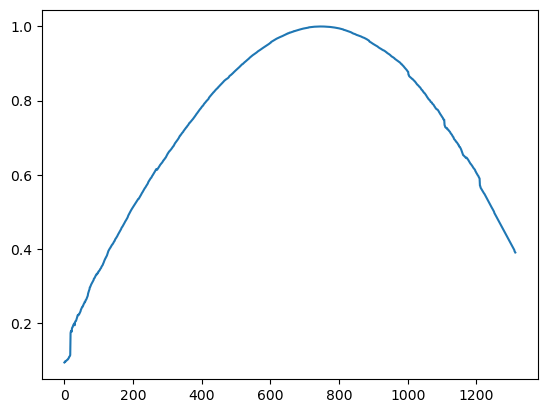

In [150]:
print(keys.LON_FWT.values)
print(np.cos(keys.LON_FWT.values))
plt.plot(np.cos(np.deg2rad(keys.LON_FWT.values)))


In [36]:
importlib.reload(ana)

re_query=False
#interval_type='non-flare'
#interval_type='all'
interval_type='flare'

with open('all_targets.pickle', 'rb') as f:
    all_targets = pickle.load(f)


    
files_with_usflx=[] 
em10s_=[]
usflxs_=[]
key_avg_usflxs=[]
key_avg_em10, key_avg_em7, key_avg_em5 = [], [], []
key_avg_powerlaws = []

for key in keys_with_harps:
    
    harps, orbits = get_harp_and_times(key, all_targets)

    res_files, tworegion = ana.get_key_resultfiles(key, fromhome=True, 
                            keydict=all_targets,
                            withparams=True)
    
    if tworegion:
        for i in range(0, 2):
            hh = harps[i]
            rfs = res_files[i]
            print('HARP: ', hh)
            if re_query:
                files_with_usflx, usflxs, em10s, em7s, em5s, powerlaws = save_usflux(rfs, hh, interp_seconds=20, 
                                                                          interval_type=interval_type, plot=True, label=key)
            else:
                files_with_usflx, usflxs, em10s, em7s, em5s, powerlaws = get_usflux(rfs, interval_type=interval_type)
                
            if usflxs:
                files_with_usflx.extend(files_with_usflx)
                em10s_.extend(em10s)
                usflxs_.extend(usflxs)
                key_avg_em10.append(np.mean(em10s))
                key_avg_em7.append(np.mean(em7s))
                key_avg_em5.append(np.mean(em5s))
                key_avg_usflxs.append(np.nanmean(usflxs, axis=0))
                key_avg_powerlaws.append(np.nanmean(powerlaws, axis=0))
            
    else:
        hh = harps[0]
        print('HARP: ', hh)
        if re_query:
            files_with_usflx, usflxs, em10s, em7s, em5s, powerlaws = save_usflux(res_files, hh, interp_seconds=20, 
                                                                      interval_type=interval_type, plot=True, label=key)
        else:
            files_with_usflx, usflxs, em10s, em7s, em5s, powerlaws = get_usflux(res_files, interval_type=interval_type)
            
        if usflxs:
            files_with_usflx.extend(files_with_usflx)
            em10s_.extend(em10s)
            usflxs_.extend(usflxs)
            key_avg_em10.append(np.mean(em10s))
            key_avg_em7.append(np.mean(em7s))
            key_avg_em5.append(np.mean(em5s))
            key_avg_usflxs.append(np.nanmean(usflxs, axis=0))
            key_avg_powerlaws.append(np.nanmean(powerlaws, axis=0))

doing  02-sep-15
HARP:  5894
HARP:  5930
doing  22-apr-16_1
HARP:  6500
doing  26-jul-16_2
HARP:  6687
doing  29-may-18_1
HARP:  7262
doing  29-may-18_2
TIS failed on at least one orbit. Orbits completed:  0
Orbits total:  1
Region was:  /Users/jmdunca2/do-dem/initial_dem_29may18_2/region_1/

29-may-18_2 0 21-16-55_21-24-25 []
29-may-18_2 0 21-24-25_21-30-55 []
29-may-18_2 0 21-30-55_21-37-35 []
HARP:  7261
HARP:  7260


/Users/jmdunca2/miniforge3/lib/python3.10/site-packages/astropy/time/formats.py:1580: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  val1_uint32 = val1.view((np.uint32, val1.dtype.itemsize // 4))


doing  09-sep-18
HARP:  7304
doing  10-sep-18
HARP:  7304
doing  12-apr-19
HARP:  7353
doing  13-apr-19
HARP:  7353
doing  29-jan-20
29-jan-20 11-12-35_11-20-10 []
29-jan-20 11-20-10_11-22-50 []
29-jan-20 11-22-50_11-23-35 []
29-jan-20 11-23-35_11-24-50 []
29-jan-20 11-24-50_11-28-30 []
29-jan-20 11-28-30_11-47-15 []
29-jan-20 11-47-15_11-53-55 []
29-jan-20 16-05-50_16-06-20 []
29-jan-20 16-06-20_16-06-50 []
29-jan-20 16-06-50_16-07-20 []
29-jan-20 16-07-20_16-07-50 []
29-jan-20 16-07-50_16-08-30 []
29-jan-20 16-08-30_16-09-10 []
29-jan-20 16-09-10_16-10-15 []
29-jan-20 16-10-15_16-18-30 []
29-jan-20 16-18-30_16-24-25 []
29-jan-20 16-24-25_16-30-50 []
29-jan-20 16-30-50_16-32-45 []
29-jan-20 16-32-45_16-41-10 []
29-jan-20 16-41-10_17-07-45 []
29-jan-20 17-48-35_17-56-00 []
29-jan-20 19-18-50_19-24-40 []
29-jan-20 19-24-40_19-28-25 []
29-jan-20 19-28-25_19-28-55 []
29-jan-20 19-28-55_19-29-25 []
29-jan-20 19-29-25_19-29-55 []
29-jan-20 19-29-55_19-30-25 []
29-jan-20 19-30-25_19-32-00 []

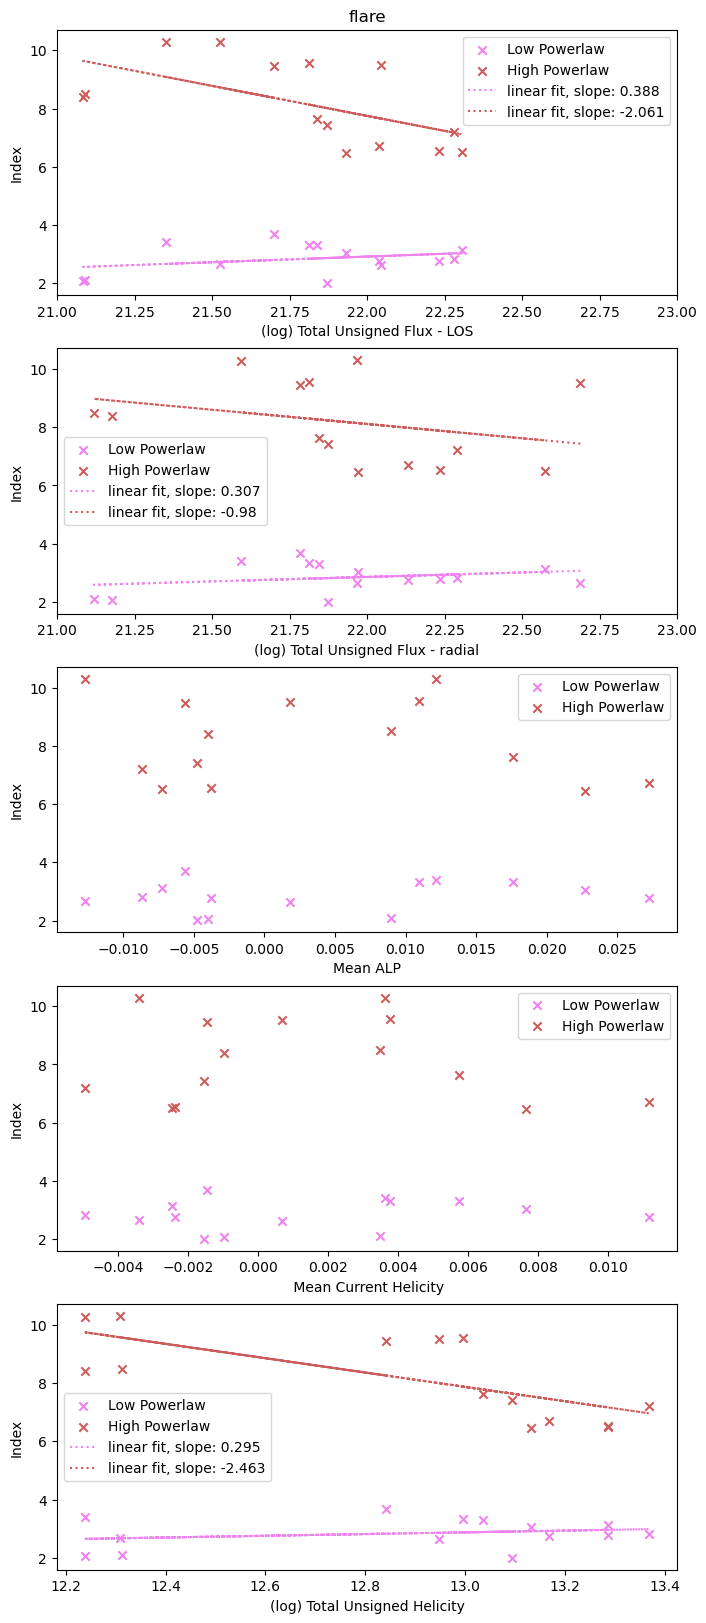

In [37]:
#Plotting magnetic parameters vs. powerlaws

avg_usflxs_arr = np.array(key_avg_usflxs)
key_avg_powerlaws_arr = np.array(key_avg_powerlaws)

fig, axes = plt.subplots(5,1, figsize=(8,20)) 

xlabelz = ['(log) Total Unsigned Flux - LOS', '(log) Total Unsigned Flux - radial', 
           'Mean ALP', ' Mean Current Helicity', '(log) Total Unsigned Helicity']

for i in range(0,len(axes)):
    ax=axes[i]
    if i in [0,1,4]:

        ax.scatter(np.log10(avg_usflxs_arr[:,i]), key_avg_powerlaws_arr[:,0], marker='x', color='violet', label='Low Powerlaw')
        ax.scatter(np.log10(avg_usflxs_arr[:,i]), -1*key_avg_powerlaws_arr[:,1], marker='x', color='indianred', label='High Powerlaw')
        ax.set_ylabel('Index')
        #lower
        m, b = np.polyfit(np.log10(avg_usflxs_arr[:,i]), key_avg_powerlaws_arr[:,0], 1)
        fity = np.array(np.log10(avg_usflxs_arr[:,i]))*m + b
        ax.plot(np.log10(avg_usflxs_arr[:,i]), fity, linestyle='dotted', color='violet', label='linear fit, slope: '+str(round(m,3)))

        #upper
        m, b = np.polyfit(np.log10(avg_usflxs_arr[:,i]), -1*key_avg_powerlaws_arr[:,1], 1)
        fity = np.array(np.log10(avg_usflxs_arr[:,i]))*m + b
        ax.plot(np.log10(avg_usflxs_arr[:,i]), fity, linestyle='dotted', color='indianred', label='linear fit, slope: '+str(round(m,3)))

        if i in [0,1]:
            ax.set_xlim([21,23])

    else:
        ax.scatter(avg_usflxs_arr[:,i], key_avg_powerlaws_arr[:,0], marker='x', color='violet', label='Low Powerlaw')
        ax.scatter(avg_usflxs_arr[:,i], -1*key_avg_powerlaws_arr[:,1], marker='x', color='indianred', label='High Powerlaw')
        ax.set_ylabel('Index')
        # m, b = np.polyfit(key_avg_em10, avg_usflxs_arr[:,i], 1)
        # fity = np.array(key_avg_em10)*m + b
        # ax.plot(key_avg_em10, fity, linestyle='dotted', color='black', label='linear fit, slope: '+str(round(m,3)))
        #ax.set_yscale('log')
        
    ax.set_xlabel(xlabelz[i])     
    ax.legend()

axes[0].set_title(interval_type)


#axes[0].set_ylim([1e20, 1e23])
#axes[0].set_xlim([1e17,0.5e23])

plt.savefig('Powerlaw_vs_SHARP_params_'+interval_type+'rm_farlimbs.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


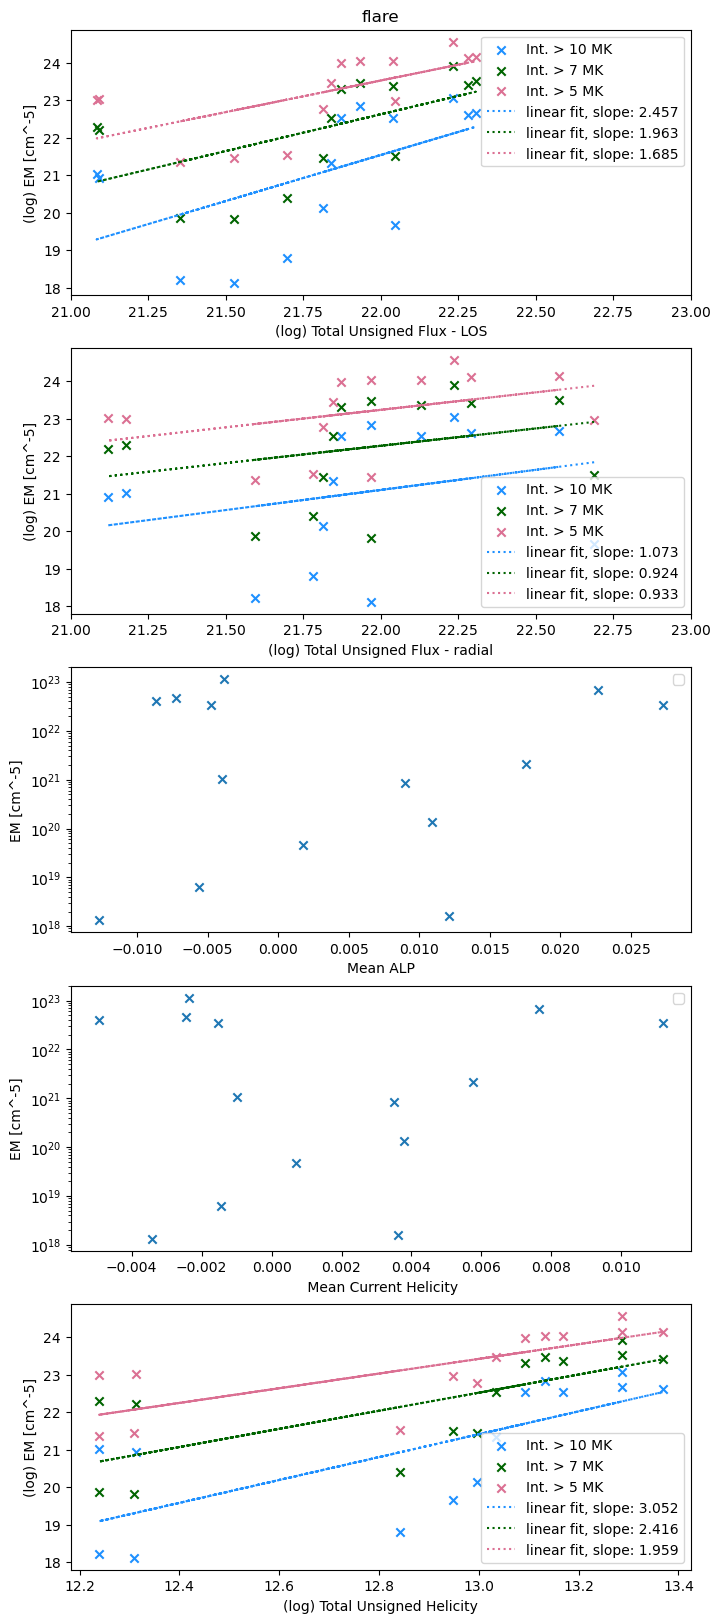

In [22]:
avg_usflxs_arr = np.array(key_avg_usflxs)

fig, axes = plt.subplots(5,1, figsize=(8,20)) 

xlabelz = ['(log) Total Unsigned Flux - LOS', '(log) Total Unsigned Flux - radial', 
           'Mean ALP', ' Mean Current Helicity', '(log) Total Unsigned Helicity']

for i in range(0,len(axes)):
    ax=axes[i]
    if i in [0,1,4]:

        ax.scatter(np.log10(avg_usflxs_arr[:,i]), np.log10(key_avg_em10), marker='x', color='dodgerblue', label='Int. > 10 MK')
        ax.scatter(np.log10(avg_usflxs_arr[:,i]), np.log10(key_avg_em7), marker='x', color='darkgreen', label='Int. > 7 MK')
        ax.scatter(np.log10(avg_usflxs_arr[:,i]), np.log10(key_avg_em5), marker='x', color='palevioletred', label='Int. > 5 MK')
        ax.set_ylabel('(log) EM [cm^-5]')
        #10 MK
        m, b = np.polyfit(np.log10(avg_usflxs_arr[:,i]), np.log10(key_avg_em10), 1)
        fity = np.array(np.log10(avg_usflxs_arr[:,i]))*m + b
        ax.plot(np.log10(avg_usflxs_arr[:,i]), fity, linestyle='dotted', color='dodgerblue', label='linear fit, slope: '+str(round(m,3)))

        #7 MK
        m, b = np.polyfit(np.log10(avg_usflxs_arr[:,i]), np.log10(key_avg_em7), 1)
        fity = np.array(np.log10(avg_usflxs_arr[:,i]))*m + b
        ax.plot(np.log10(avg_usflxs_arr[:,i]), fity, linestyle='dotted', color='darkgreen', label='linear fit, slope: '+str(round(m,3)))

        #5 MK
        m, b = np.polyfit(np.log10(avg_usflxs_arr[:,i]), np.log10(key_avg_em5), 1)
        fity = np.array(np.log10(avg_usflxs_arr[:,i]))*m + b
        ax.plot(np.log10(avg_usflxs_arr[:,i]), fity, linestyle='dotted', color='palevioletred', label='linear fit, slope: '+str(round(m,3)))
        
        if i in [0,1]:
            ax.set_xlim([21,23])

    else:
        ax.scatter(avg_usflxs_arr[:,i], key_avg_em10, marker='x')
        ax.set_ylabel('EM [cm^-5]')
        # m, b = np.polyfit(key_avg_em10, avg_usflxs_arr[:,i], 1)
        # fity = np.array(key_avg_em10)*m + b
        # ax.plot(key_avg_em10, fity, linestyle='dotted', color='black', label='linear fit, slope: '+str(round(m,3)))
        ax.set_yscale('log')
        
    ax.set_xlabel(xlabelz[i])     
    ax.legend()

axes[0].set_title(interval_type)


#axes[0].set_ylim([1e20, 1e23])
#axes[0].set_xlim([1e17,0.5e23])

plt.savefig('EM_vs_SHARP_params_'+interval_type+'rm_farlimbs.png')

In [60]:
np.log(key_avg_em10)

array([44.75756605, 44.23356641, 47.62135306, 43.06924709, 41.14276712,
       49.19672166, 49.35102469, 52.09912517, 48.55950184, 48.23127551,
       48.59040887, 48.78684961, 41.04627067, 41.08680974, 41.68842595])

/var/folders/55/06y21cm93w70z_8gl7yxv2t40000gq/T/ipykernel_28631/350642483.py:9: RuntimeWarning: invalid value encountered in log10
  ax.scatter(np.log10(em10s_), np.log10(usflxs_arr[:,i]), marker='x')
/var/folders/55/06y21cm93w70z_8gl7yxv2t40000gq/T/ipykernel_28631/350642483.py:15: RuntimeWarning: invalid value encountered in log10
  m, b = np.polyfit(np.log10(em10s_), np.log10(usflxs_arr[:,i]), 1)


Text(0.5, 1.0, 'Non-flaring times')

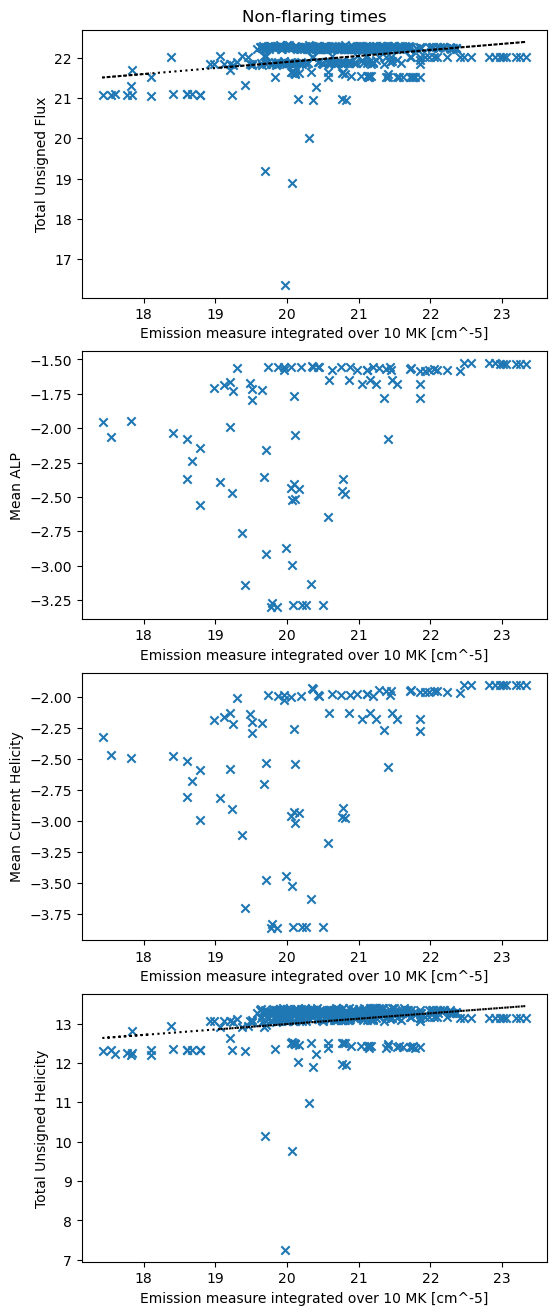

In [65]:
usflxs_arr = np.array(usflxs_)

fig, axes = plt.subplots(4,1, figsize=(6,16)) 

xlabelz = ['Total Unsigned Flux', 'Mean ALP', 'Mean Current Helicity', 'Total Unsigned Helicity']

for i in range(0,len(axes)):
    ax=axes[i]
    ax.scatter(np.log10(em10s_), np.log10(usflxs_arr[:,i]), marker='x')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.set_xlabel('Emission measure integrated over 10 MK [cm^-5]')
    ax.set_ylabel(xlabelz[i])   

    m, b = np.polyfit(np.log10(em10s_), np.log10(usflxs_arr[:,i]), 1)
    fity = np.array(np.log10(em10s_))*m + b
    ax.plot(np.log10(em10s_), fity, linestyle='dotted', color='black', label='linear fit, slope: '+str(round(m,3)))

axes[0].set_title('Non-flaring times')


#axes[0].set_ylim([1e20, 1e23])
#axes[0].set_xlim([1e17,0.5e23])

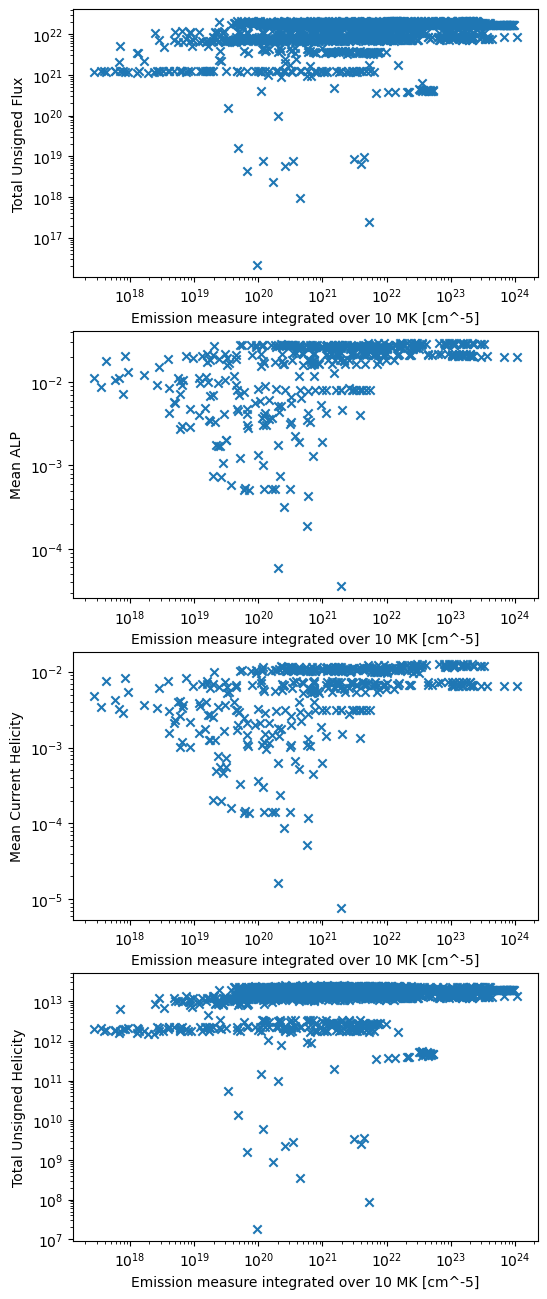

In [27]:
usflxs_arr = np.array(usflxs_)

fig, axes = plt.subplots(4,1, figsize=(6,16)) 

xlabelz = ['Total Unsigned Flux', 'Mean ALP', 'Mean Current Helicity', 'Total Unsigned Helicity']

for i in range(0,len(axes)):
    ax=axes[i]
    ax.scatter(em10s_, usflxs_arr[:,i], marker='x')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('Emission measure integrated over 10 MK [cm^-5]')
    ax.set_ylabel(xlabelz[i])           

In [ ]:
np.array(usflux)
t_rec
every_30s

In [ ]:
fig, ax = plt.subplots(figsize=(8,7))      # define the size of the figure
orangered = (1.0,0.27,0,1.0)                # create an orange-red color

# define some style elements
marker_style = dict(linestyle='', markersize=8, fillstyle='full',color=orangered,markeredgecolor=orangered)
text_style = dict(fontsize=16, fontdict={'family': 'monospace'})
ax.tick_params(labelsize=14)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

# ascribe the data to the axes
ax.plot(t_rec, (keys.USFLUX)/(1e22),'o',**marker_style)
ax.errorbar(t_rec, (keys.USFLUX)/(1e22), yerr=(keys.ERRVF)/(1e22), linestyle='',color=orangered)

# format the x-axis with universal time
locator = AutoDateLocator()
locator.intervald[HOURLY] = [12] # only show every 3 hours
formatter = DateFormatter('%H')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# set yrange 
#ax.set_ylim([2.4,2.8])

# label the axes and the plot
ax.set_xlabel('time in UT',**text_style)
ax.set_ylabel('maxwells x 1e22',**text_style)
ax.set_title('total unsigned flux starting at '+str(t_rec[0])+' UT',**text_style) # annotate the plot with a start time


In [ ]:
obsids=[]
for id in id_dirs:
    evt_data, hdr, obsid = nu.return_submap(datapath=id, fpm='A', return_evt_hdr=True, return_obsid=True)
    obsids.append(obsid)
    time0, time1 = [nuutil.convert_nustar_time(hdr['TSTART']), nuutil.convert_nustar_time(hdr['TSTOP'])]
    timerange = [time0, time1]
    print(timerange[0].strftime('%H-%M-%S'), timerange[1].strftime('%H-%M-%S'))
    